# Basic Neural Nets with Backpropagation from scratch

This notebook shows how to implement neural nets from scratch to do multi-class classification of digits!

![Handwritten digits grid](img/handwritten_digits.png?raw=true "Handwritten digits grid")

This code was ported from Octave/Matlab to python and was part of the absolutely excellent [Machine Learning course](http://ml-class.org) by Stanford's [Andrew Ng](http://www.andrewng.org) on Coursera.

## Neural Networks Learning
In this exercise, you will implement the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

In [5]:
import scipy.io
import scipy.optimize as opt
from scipy.special import expit 
import numpy as np

Then set up the parameters for the simple neural net:

In [6]:
## Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 1 to 10
                        # (note that we have mapped "0" to label 10)

We'll have an architecture with three layers: the input layer (the training data), a hidden layer (which learns its own feature representations), and an output data (the labels). This is a rough illustration of our neural net:

![Neural nets architecture with equations.png](img/neural-net-architecture-equations.png?raw=true "Neural nets architecture with equations")

## Visualization

We can visualize 100 random data points (out of the 5,000 in the data set) with the ``displayData()`` function. you can see more comments on many lines' particular functions, for this or any section going forward. 

I found that applying ``flatten()`` to the labels ``y`` is crucial in getting good performance - otherwise the minimization isn't very effective. What it does is change the dimension of the labels from ``(m,1)`` to ``(m,)``, which in ``numpy`` can have significantly different behaviours in different functions.

In [8]:
import math
import matplotlib.pyplot as plt

def displayData(X, example_width=None):
    plt.close()
    # creates new figure 
    plt.figure(figsize=(10, 10))
    # turns 1D X array into 2D
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))

    # Set example_width automatically if not passed in
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))

    # Gray Image
    plt.set_cmap("gray")

    # Compute rows, cols
    m, n = X.shape
    example_height = n // example_width

    # Compute number of items to display
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m // display_rows))
    #print("display_rows:",display_rows,"display_cols:",display_cols)
    # Between images padding
    pad = 1

    # Setup blank display
    print("display_rows:",(pad + display_rows * (example_height + pad)),"display_cols:",(pad + display_cols * (example_width + pad)))
    display_array = -np.ones((pad + display_rows * (example_height + pad),  pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break

            # Copy the patch
            # Get the max value of the patch to normalize all examples
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width ))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (example_height, example_width), order="F") / max_val
            curr_ex += 1

        if curr_ex > m:
            break
    # Display Image
    h = plt.imshow(display_array, vmin=-1, vmax=1)
    # Do not show axis
    plt.axis('off')
    plt.show(block=False)
    return h, display_array


Loading and Visualizing Data ...
display_rows: 211 display_cols: 211


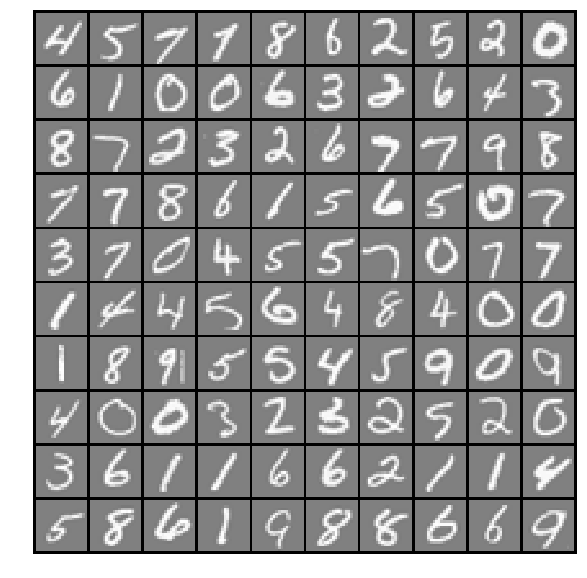

In [9]:

## =========== Part 1: Loading and Visualizing Data =============
#  We start the exercise by first loading and visualizing the dataset. 
#  You will be working with a dataset that contains handwritten digits.
#

# Load Training Data
print('Loading and Visualizing Data ...')
mat = scipy.io.loadmat('data/ex4data1.mat')
X = mat["X"]
y = mat["y"]
# crucial step in getting good performance!
# changes the dimension from (m,1) to (m,)
# otherwise the minimization isn't very effective...
y=y.flatten() 

#Randomly select 100 data points to display
m,n = X.shape
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100],:]
_, _ = displayData(sel)

## Cost function


$\begin{gather*} J(\Theta) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \left[y^{(i)}_k \log ((h_\Theta (x^{(i)}))_k) + (1 - y^{(i)}_k)\log (1 - (h_\Theta(x^{(i)}))_k)\right] + \frac{\lambda}{2m}\sum_{l=1}^{L-1} \sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} ( \Theta_{j,i}^{(l)})^2\end{gather*}$
$cost =0 \\ \text{for}\quad i = 0 \; to \; m \\ \quad cost += y^{(i)}_k \log ((h_\Theta (x^{(i)}))_k) + (1 - y^{(i)}_k)\log (1 - (h_\Theta(x^{(i)}))_k) \\ J(\Theta) = - \frac{1}{m} * cost \\ \\J(\Theta) += \frac{\lambda}{2m}+\text(sum\_of\_theta)$

Now we load some pretrained weights to easily implement the first few parts of the network:

In [32]:
## ================ Part 2: Loading Parameters ================
# In this part of the exercise, we load some pre-initialized 
# neural network parameters.

print('Loading Saved Neural Network Parameters ...')

# Load the weights into variables Theta1 and Theta2
weights = scipy.io.loadmat('data/ex4weights.mat')
Theta1 = weights["Theta1"]
Theta2 = weights["Theta2"]

# Unroll parameters 
# ndarray.flatten() always creates copy (http://stackoverflow.com/a/28930580/583834)
# ndarray.ravel() requires transpose to have matlab unrolling order (http://stackoverflow.com/a/15988852/583834)
# np.append() always makes a copy (http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.append.html)
nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))

Loading Saved Neural Network Parameters ...


In [22]:
def sigmoid(z):
    """Computes the sigmoid of z.
    """
    g = np.zeros(z.shape)
    g = expit(z)
    return g

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function for a two layer
    neural network which performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad


And we test the nnCostFunction() function to ensure we get the expected value of 0.287629:

In [23]:
## ================ Part 3: Compute Cost (Feedforward) ================
#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.
#
print('Feedforward Using Neural Network ...')
# # Weight regularization parameter (we set this to 0 here).
lambda_reg = 0

J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_reg)


print('Training Set Accuracy: {:f}\n(this value should be about 0.287629)'.format(J))

Feedforward Using Neural Network ...
Training Set Accuracy: 0.287629
(this value should be about 0.287629)


### Regularization

Now, to the cost function above, we add regularization. Regularization helps prevent overfitting! We now expect a cost, again using the pretrained weights, of 0.383770.


In [27]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size,\
                   num_labels,X, y, lambda_reg):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')
    # Setup some useful variables
    m = len(X)
             
    # # You need to return the following variables correctly 
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )

    # ====================== YOUR CODE HERE ======================
    
    a1=np.column_stack((np.ones((m,1)), X))
    z2=np.dot(a1,Theta1.T)
    a2=np.column_stack((np.ones((z2.shape[0], 1)) ,sigmoid(z2)))
    z3=np.dot(a2,Theta2.T)
    a3=sigmoid(z3)
    
    # recode labels as vectors containing only values 0 or 1
    labels = y
    # set y to be matrix of size m x k
    y = np.zeros((m,num_labels))
    # for every label, convert it into vector of 0s and a 1 in the appropriate position
    # one-hot encoding
    for i in xrange(m):
        y[i, labels[i]-1] = 1
    
    # at this point, both a3 and y are m x k matrices, where m is the number of inputs
    # and k is the number of hypotheses. Given that the cost function is a sum
    # over m and k, loop over m and in each loop, sum over k by doing a sum over the row

    cost = 0
    for i in range(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost

    # REGULARIZED COST FUNCTION
    # note that Theta1[:,1:] is necessary given that the first column corresponds to transitions
    # from the bias terms, and we are not regularizing those parameters. Thus, we get rid
    # of the first column.

    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))

    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )
    
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

     # Unroll gradients
    return J, grad

In [28]:
## =============== Part 4: Implement Regularization ===============
#  Once your cost function implementation is correct, you should now
#  continue to implement the regularization with the cost.

print('Checking Cost Function (w/ Regularization)...')

# Weight regularization parameter (we set this to 1 here).
lambda_reg = 1

J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
                   num_labels, X, y, lambda_reg)

print('Cost at parameters (loaded from ex4weights): {:f}\n(this value should be about 0.383770)'.format(J))

Checking Cost Function (w/ Regularization)...
Cost at parameters (loaded from ex4weights): 0.383770
(this value should be about 0.383770)


## Backpropagation

The backpropagation algorithm is on of the main reasons why neural networks are so powerful- by backpropagating the error from the output layer back to the hidden layer(s), a neural net learns its own features and can create better representations of the data than manual feature engineering can.

We start with defining and demonstrating a function to calculate the sigmoid gradient:

In [29]:
def sigmoidGradient(z):
    #SIGMOIDGRADIENT returns the gradient of the sigmoid function
    g=sigmoid(z);
    #g = 1 - (sig'*sig)
    g = g*(1-g)
    return g

In [33]:
## ================ Part 5: Sigmoid Gradient  ================
#  Before you start implementing the neural network, you will first
#  implement the gradient for the sigmoid function. You should complete the
#  code in the sigmoidGradient.m file.
#

print('Evaluating sigmoid gradient...')

g = sigmoidGradient( np.array([1, -0.5, 0, 0.5, 1]) )
print('Sigmoid gradient evaluated at [1, -0.5, 0, 0.5, 1]:')
print(g)

Evaluating sigmoid gradient...
Sigmoid gradient evaluated at [1, -0.5, 0, 0.5, 1]:
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


An important part of a neural network with our architecture is "symmetry breaking": a random intialization of the weights. Otherwise, all the weights are modified in exactly the same way, which leads to very little learning. The function ``randInitializeWeights()`` serves this purpose:

In [34]:
def randInitializeWeights(L_in, L_out):
    #RANDINITIALIZEWEIGHTS Randomly initialize the weights of a layer with L_in
    #incoming connections and L_out outgoing connections
    #   W = RANDINITIALIZEWEIGHTS(L_in, L_out) randomly initializes the weights 
    #   of a layer with L_in incoming connections and L_out outgoing 
    #   connections. 
    #
    #   Note that W should be set to a matrix of size(L_out, 1 + L_in) as
    #   the column row of W handles the "bias" terms
    #

    # You need to return the following variables correctly 
    W = np.zeros((L_out, 1 + L_in))

    # ====================== YOUR CODE HERE ======================
    # Instructions: Initialize W randomly so that we break the symmetry while
    #               training the neural network.
    #
    # Note: The first row of W corresponds to the parameters for the bias units
    #

    # Randomly initialize the weights to small values
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init

    return W

In [35]:
## ================ Part 6: Initializing Pameters ================
#  In this part of the exercise, you will be starting to implment a two
#  layer neural network that classifies digits. You will start by
#  implementing a function to initialize the weights of the neural network
#  (randInitializeWeights.m)

print('Initializing Neural Network Parameters...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate((initial_Theta1.reshape(initial_Theta1.size, order='F'), initial_Theta2.reshape(initial_Theta2.size, order='F')))

Initializing Neural Network Parameters...


Now we implement the backpropagation algorithm. Backpropagation happens after the feedforward pass where, with our initial random weights, a cost is calculated. The backpropagation of this cost means that for each node in each layer, we can measure how much that node contributed to the error, or cost, from the forward pass.

![Neural nets architecture with equations.png](img/backprop.png?raw=true "Backpropagation architecture with equations")

To implement this we build on our ``nnCostFunctionX()`` function by adding proper calculations for the ``grad`` return values

In [36]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function with regularization
    plus backpropagation for a two layer neural network which 
    performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    # one-hot encoding
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost
    
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))

    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )

    bigDelta1 = 0
    bigDelta2 = 0
    
    # iterate over training examples
    for t in xrange(m):
        ## forward pass
        # t-th row of X
        x = X[t]
        
        # sigmoid( z2 ) where z2 = Theta1 * a1
        a2 = sigmoid( np.dot(x,Theta1.T) )

        # bias unit
        a2 = np.concatenate((np.array([1]), a2))
        # sigmoid ( z3 ) where z3 = Theta2 * a2
        a3 = sigmoid( np.dot(a2,Theta2.T) )

        ## for each output unit k in layer 3, set delta_{k}^{(3)}
        delta3 = np.zeros((num_labels))

        # whether current training example belongs to class k (y_k = 1), 
        # or if it belongs to a different class (y_k = 0)
        for k in xrange(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k

        ## delta2 = Theta2' * delta3 .* sigmoidGradient(z2), skipping bias unit gradients
        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )

        ## step 4: accumulate gradient from this example
        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)

    # step 5: obtain gradient for neural net cost function by dividing the accumulated gradients by m
    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad

It's easy to get backpropagation details wrong. To verify that it's properly implemented, we do gradient checking. This is a numerical verification layer that serves to verify any function that computes a cost and a gradient.

Note that ``checkNNGradients()`` actually creates a small neural network with a small number of input and hidden units that keeps the number of parameters low. This is because calculating the numerical gradients can be expensive, and the only purpose of running this function with a mock neural is to ensure the cost function is doing backprop properly.

In [37]:
def debugInitializeWeights(fan_out, fan_in):
    #DEBUGINITIALIZEWEIGHTS Initialize the weights of a layer with fan_in
    #incoming connections and fan_out outgoing connections using a fixed
    #strategy, this will help you later in debugging
    #   W = DEBUGINITIALIZEWEIGHTS(fan_in, fan_out) initializes the weights 
    #   of a layer with fan_in incoming connections and fan_out outgoing 
    #   connections using a fix set of values
    #
    #   Note that W should be set to a matrix of size(1 + fan_in, fan_out) as
    #   the first row of W handles the "bias" terms
    #

    # Set W to zeros
    W = np.zeros((fan_out, 1 + fan_in))

    # Initialize W using "sin", this ensures that W is always of the same
    # values and will be useful for debugging
    W = np.reshape(np.sin(range(W.size)), W.shape) / 10

    return W
def computeNumericalGradient(J, theta):
    #COMPUTENUMERICALGRADIENT Computes the gradient using "finite differences"
    #and gives us a numerical estimate of the gradient.
    #   numgrad = COMPUTENUMERICALGRADIENT(J, theta) computes the numerical
    #   gradient of the function J around theta. Calling y = J(theta) should
    #   return the function value at theta.

    # Notes: The following code implements numerical gradient checking, and 
    #        returns the numerical gradient.It sets numgrad(i) to (a numerical 
    #        approximation of) the partial derivative of J with respect to the 
    #        i-th input argument, evaluated at theta. (i.e., numgrad(i) should 
    #        be the (approximately) the partial derivative of J with respect 
    #        to theta(i).)
    #                

    numgrad = np.zeros( theta.shape )
    perturb = np.zeros( theta.shape )
    e = 1e-4

    for p in xrange(theta.size):
        # Set perturbation vector
        perturb.reshape(perturb.size, order="F")[p] = e
        loss1, _ = J(theta - perturb)
        loss2, _ = J(theta + perturb)
        # Compute Numerical Gradient
        numgrad.reshape(numgrad.size, order="F")[p] = (loss2 - loss1) / (2*e)
        perturb.reshape(perturb.size, order="F")[p] = 0

    return numgrad
def checkNNGradients(lambda_reg=0):
    #CHECKNNGRADIENTS Creates a small neural network to check the
    #backpropagation gradients
    #   CHECKNNGRADIENTS(lambda) Creates a small neural network to check the
    #   backpropagation gradients, it will output the analytical gradients
    #   produced by your backprop code and the numerical gradients (computed
    #   using computeNumericalGradient). These two gradient computations should
    #   result in very similar values.
    #

    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(m, input_layer_size - 1)
    y  = 1 + np.mod(range(m), num_labels).T

    # Unroll parameters
    nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))

    # Short hand for cost function
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size, \
                                   num_labels, X, y, lambda_reg);

    _, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    # code from http://stackoverflow.com/a/27663954/583834
    fmt = '{:<25}{}'
    print(fmt.format('Numerical Gradient', 'Analytical Gradient'))
    for numerical, analytical in zip(numgrad, grad):
        print(fmt.format(numerical, analytical))

    print('The above two columns you get should be very similar.\n' \
             '(Left Col.: Your Numerical Gradient, Right Col.: Analytical Gradient)')

    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # in computeNumericalGradient.m, then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)

    print('If your backpropagation implementation is correct, then \n' \
             'the relative difference will be small (less than 1e-9). \n' \
             '\nRelative Difference: {:.10E}'.format(diff))

In [38]:
## =============== Part 7: Implement Backpropagation ===============
#  Once your cost matches up with ours, you should proceed to implement the
#  backpropagation algorithm for the neural network. You should add to the
#  code you've written in nnCostFunction.m to return the partial
#  derivatives of the parameters.
#
print('Checking Backpropagation... ')

#  Check gradients by running checkNNGradients
checkNNGradients()

Checking Backpropagation... 
Numerical Gradient       Analytical Gradient
0.006906540832574137     0.006906540840162155
0.012125104260629627     0.012125104269759579
0.006198479014507541     0.006198479017045424
-0.005423556832528931    -0.005423556834022436
-0.012076102853253445    -0.012076102864730183
-0.00011085270923416601  -0.00011085270971864139
-4.2982200021413064e-05  -4.298220175600262e-05
6.418726883339332e-05    6.418726575059826e-05
0.00011254971621355025   0.00011254971783297646
5.7200055803008354e-05   5.720005709677367e-05
0.00014385183710885485   0.0001438518341639932
0.00015166618849704605   0.0001516661872600689
2.030122292495662e-05    2.030122346359648e-05
-0.0001300184759855938   -0.00013001847547908295
-0.00016050035522852113  -0.0001605003560819434
0.00026629966454194687   0.00026629966512297493
0.00020687338064817595   0.00020687338315369123
-4.224967042887329e-05   -4.224967005194708e-05
-0.0002530482823281943   -0.00025304828204659384
-0.0002306374824456725  

If backpropagation is implemented properly, the relative difference should be less than 1e-9. In this case, it's 1.97e-11!

## Backpropagation and regularization

Now we add the last component of our cost function - regularization after backpropagation:

In [39]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
    num_labels, X, y, lambda_reg):
    """Implements the neural network cost function and backpropagation
    with regularization for a two layer neural network which 
    performs classification
    """
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')

    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    labels = y    
    y = np.zeros((m,num_labels))
    
    for i in xrange(m):
        y[i, labels[i]-1] = 1
        
    cost = 0
    for i in xrange(m):
        cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )

    J = -(1.0/m)*cost
    
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))

    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )

    bigDelta1 = 0
    bigDelta2 = 0
    
    for t in xrange(m):
        x = X[t]
        a2 = sigmoid( np.dot(x,Theta1.T) )
        a2 = np.concatenate((np.array([1]), a2))
        a3 = sigmoid( np.dot(a2,Theta2.T) )
        delta3 = np.zeros((num_labels))
        
        for k in xrange(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k

        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )

        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)


    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m

    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]

    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), 
                           Theta2_grad.reshape(Theta2_grad.size, order='F')))

    return J, grad

And we check that backpropagation is working properly:

In [40]:
## =============== Part 8: Implement Regularization ===============
#  Once your backpropagation implementation is correct, you should now
#  continue to implement the regularization with the cost and gradient.
#

print('\nChecking Backpropagation (w/ Regularization) ... \n')

#  Check gradients by running checkNNGradients
lambda_reg = 3
checkNNGradients(lambda_reg)


Checking Backpropagation (w/ Regularization) ... 

Numerical Gradient       Analytical Gradient
0.006906540832574137     0.006906540840162155
0.012125104260629627     0.012125104269759579
0.006198479014507541     0.006198479017045424
-0.005423556832528931    -0.005423556834022436
-0.012076102853253445    -0.012076102864730183
0.05037740637980903      0.050377406378755145
-0.057578438679151134    -0.05757843868154431
0.024791296384663042     0.02479129638025599
0.025322571926000847     0.025322571927431432
-0.05762664945674345     -0.05762664945567663
0.05470169744725695      0.0547016974437049
-0.01661326370472338     -0.01661326370467548
-0.03262096543110715     -0.03262096542989859
0.059306422866001185     0.05930642286621314
-0.04521973516080635     -0.045219735162382514
0.008733500147517503     0.008733500148715007
0.039626069303633216     0.039626069306281035
-0.06004166206441397     -0.06004166206309416
0.038764222127785075     0.03876422212738042
0.008761995098360842     0.0087

And we make sure that the cost with our debugging parameter of ``lambda = 3`` is the expected 0.576051:

In [41]:
# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size, \
                          hidden_layer_size, num_labels, X, y, lambda_reg)

print('\n\nCost at (fixed) debugging parameters (w/ lambda_reg = 3): {:f} ' \
         '\n(this value should be about 0.576051)\n\n'.format(debug_J))



Cost at (fixed) debugging parameters (w/ lambda_reg = 3): 0.576051 
(this value should be about 0.576051)




Success!

## Neural net training

Now we use ``scipy.optimize``'s [``minimize()``](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html) to learn a good set of parameters by numerically minimizing the cost function defined above:

In [15]:
## =================== Part 8: Training NN ===================
#  You have now implemented all the code necessary to train a neural 
#  network. To train your neural network, we will now use "fmincg", which
#  is a function which works similarly to "fminunc". Recall that these
#  advanced optimizers are able to train our cost functions efficiently as
#  long as we provide them with the gradient computations.
#
print('Training Neural Network...')

#  After you have completed the assignment, change the MaxIter to a larger
#  value to see how more training helps.
#  You should also try different values of lambda_reg
#  note that scipy.optimize.minimize() can use a few different solver 
#   methods for gradient descent: 
#   http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
maxiter = 20
lambda_reg = 0.1
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lambda_reg)
results = opt.minimize(nnCostFunction, x0=nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

nn_params = results["x"]

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                 (hidden_layer_size, input_layer_size + 1), order='F')

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                 (num_labels, hidden_layer_size + 1), order='F')


Training Neural Network...


## Visualizing the hidden units

As mentioned before, one of the powerful aspects of a neural net is its ability to learn features. By visualizing the hidden units - the units between the data and the labels - we get a glimpse at the representations it learns from the handwritten digits. As mentioned in the accompanying [ex4.pdf](assignment/ex4.pdf) to the exercise, "the hidden units correspond roughly to detectors that look for strokes and other patterns in the input."


Visualizing Neural Network... 

display_rows: 106 display_cols: 106


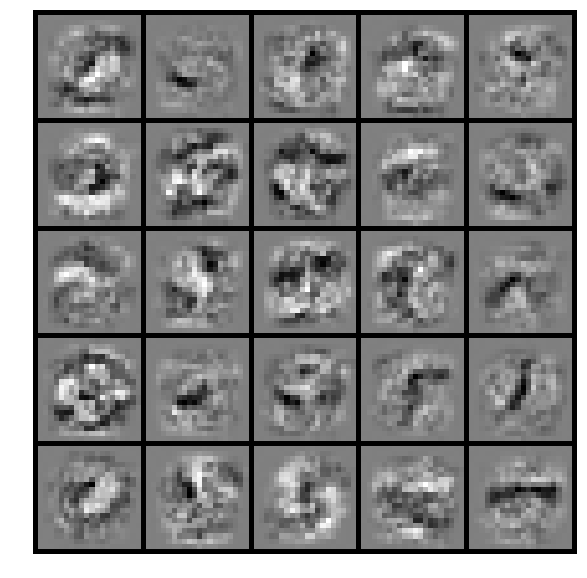

In [43]:
## ================= Part 9: Visualize Weights =================
#  You can now "visualize" what the neural network is learning by 
#  displaying the hidden units to see what features they are capturing in 
#  the data.

print('\nVisualizing Neural Network... \n')

_, _ =displayData(Theta1[:, 1:])

## Prediction accuracy

Lastly, we use the neural network learned parameters to predict labels. We also report the neural net's accuracy, which should be at least around 95%:

In [44]:
def predict(Theta1, Theta2, X):
    #PREDICT Predict the label of an input given a trained neural network
    #   p = PREDICT(Theta1, Theta2, X) outputs the predicted label of X given the
    #   trained weights of a neural network (Theta1, Theta2)
    # turns 1D X array into 2D
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))

    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros((m,1))

    h1 = sigmoid( np.dot( np.column_stack( ( np.ones((m,1)), X ) ) , Theta1.T ) )
    h2 = sigmoid( np.dot( np.column_stack( ( np.ones((m,1)), h1) ) , Theta2.T ) )

    p = np.argmax(h2, axis=1)
    return p + 1 # offsets python's zero notation

In [45]:
## ================= Part 10: Implement Predict =================
#  After training the neural network, we would like to use it to predict
#  the labels. You will now implement the "predict" function to use the
#  neural network to predict the labels of the training set. This lets
#  you compute the training set accuracy.

pred = predict(Theta1, Theta2, X)

# uncomment code below to see the predictions that don't match
# fmt = '{}   {}'
# print(fmt.format('y', 'pred'))
# for y_elem, pred_elem in zip(y, pred):
#     if y_elem != pred_elem:
#         print(fmt.format(y_elem%10, pred_elem%10))

print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y)*100 ) ) )

Training Set Accuracy: 97.520000
